# Logical Error Rate Evaluation (rotated surface code)

In [1]:
# This cell is tagged `parameters` and will be override by `papermill`
decoder: str = "mwpm"
json_filename: str | None = None  # where to save the result, will set automatically according to decoder, 

slurm_maximum_jobs: int = 360
slurm_cores_per_node: int = 18  # (slurm_maximum_jobs // slurm_cores_per_node) should not exceed 200
slurm_mem_per_job: int = 3  # 3GB per job
slurm_walltime: str = "1-00:00:00"
slurm_partition: str = "scavenge"

local_maximum_jobs = 10

target_precision: float = 0.03  # target to achieve this precision for each data point
mark_finished: bool = False  # only plot the figure and do not run experiments
shudown_cluster: bool | None = None  # by default shutdown on cluster and do not shutdown on local machine

In [2]:
from slugify import slugify
if json_filename is None:
    json_filename = slugify(decoder) + ".json"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from qec_lego_bench.hpc.monte_carlo import *
from qec_lego_bench.hpc.submitter import *
from qec_lego_bench.hpc.plotter import *
from typing import Iterable
from qec_lego_bench.cli.logical_error_rate import logical_error_rate

### Define the job list

In [5]:
d_vec = [3, 5, 7, 9, 11]
p_vec = [0.03 * 0.1 ** (i / 8) for i in range(1, 24)]

# d_vec = [3]
# p_vec = [0.01, 0.03]

jobs = [MonteCarloJob(d=d, p=p) for d in d_vec for p in p_vec]


def monte_carlo_function(shots: int, d: int, p: float) -> tuple[int, LogicalErrorResult]:
    stats = logical_error_rate(decoder=decoder, code=f"rsc(d={d},p={p})", max_shots=shots, max_errors=shots, no_progress=True, no_print=True)
    return stats.shots, LogicalErrorResult(errors=stats.errors, discards=stats.discards)

monte_carlo_function(1000, min(d_vec), max(p_vec))

(1000, LogicalErrorResult(errors=204, discards=0))

### Define the strategy to submit jobs

In [6]:
min_shots_submitter = MinShotsSubmitter(shots=10000)
precision_submitter = PrecisionSubmitter(time_limit=10*3600, min_precision=1)
more_precision_submitter = PrecisionSubmitter(time_limit=50*3600, min_precision=2)
def submitter(jobs: Iterable[MonteCarloJob]) -> list[tuple[MonteCarloJob, int]]:
    submit = min_shots_submitter(jobs)
    submit += precision_submitter(jobs)
    if len(submit) == 0 and all([job.pending_shots == 0 for job in jobs]):  # previous submitter all finished
        submit += more_precision_submitter(jobs)
    return submit

### Define the callback, e.g. plotting the intermediate result and the list of remaining tasks

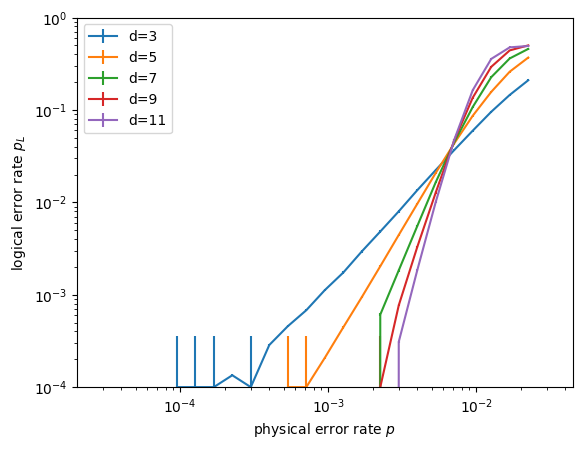

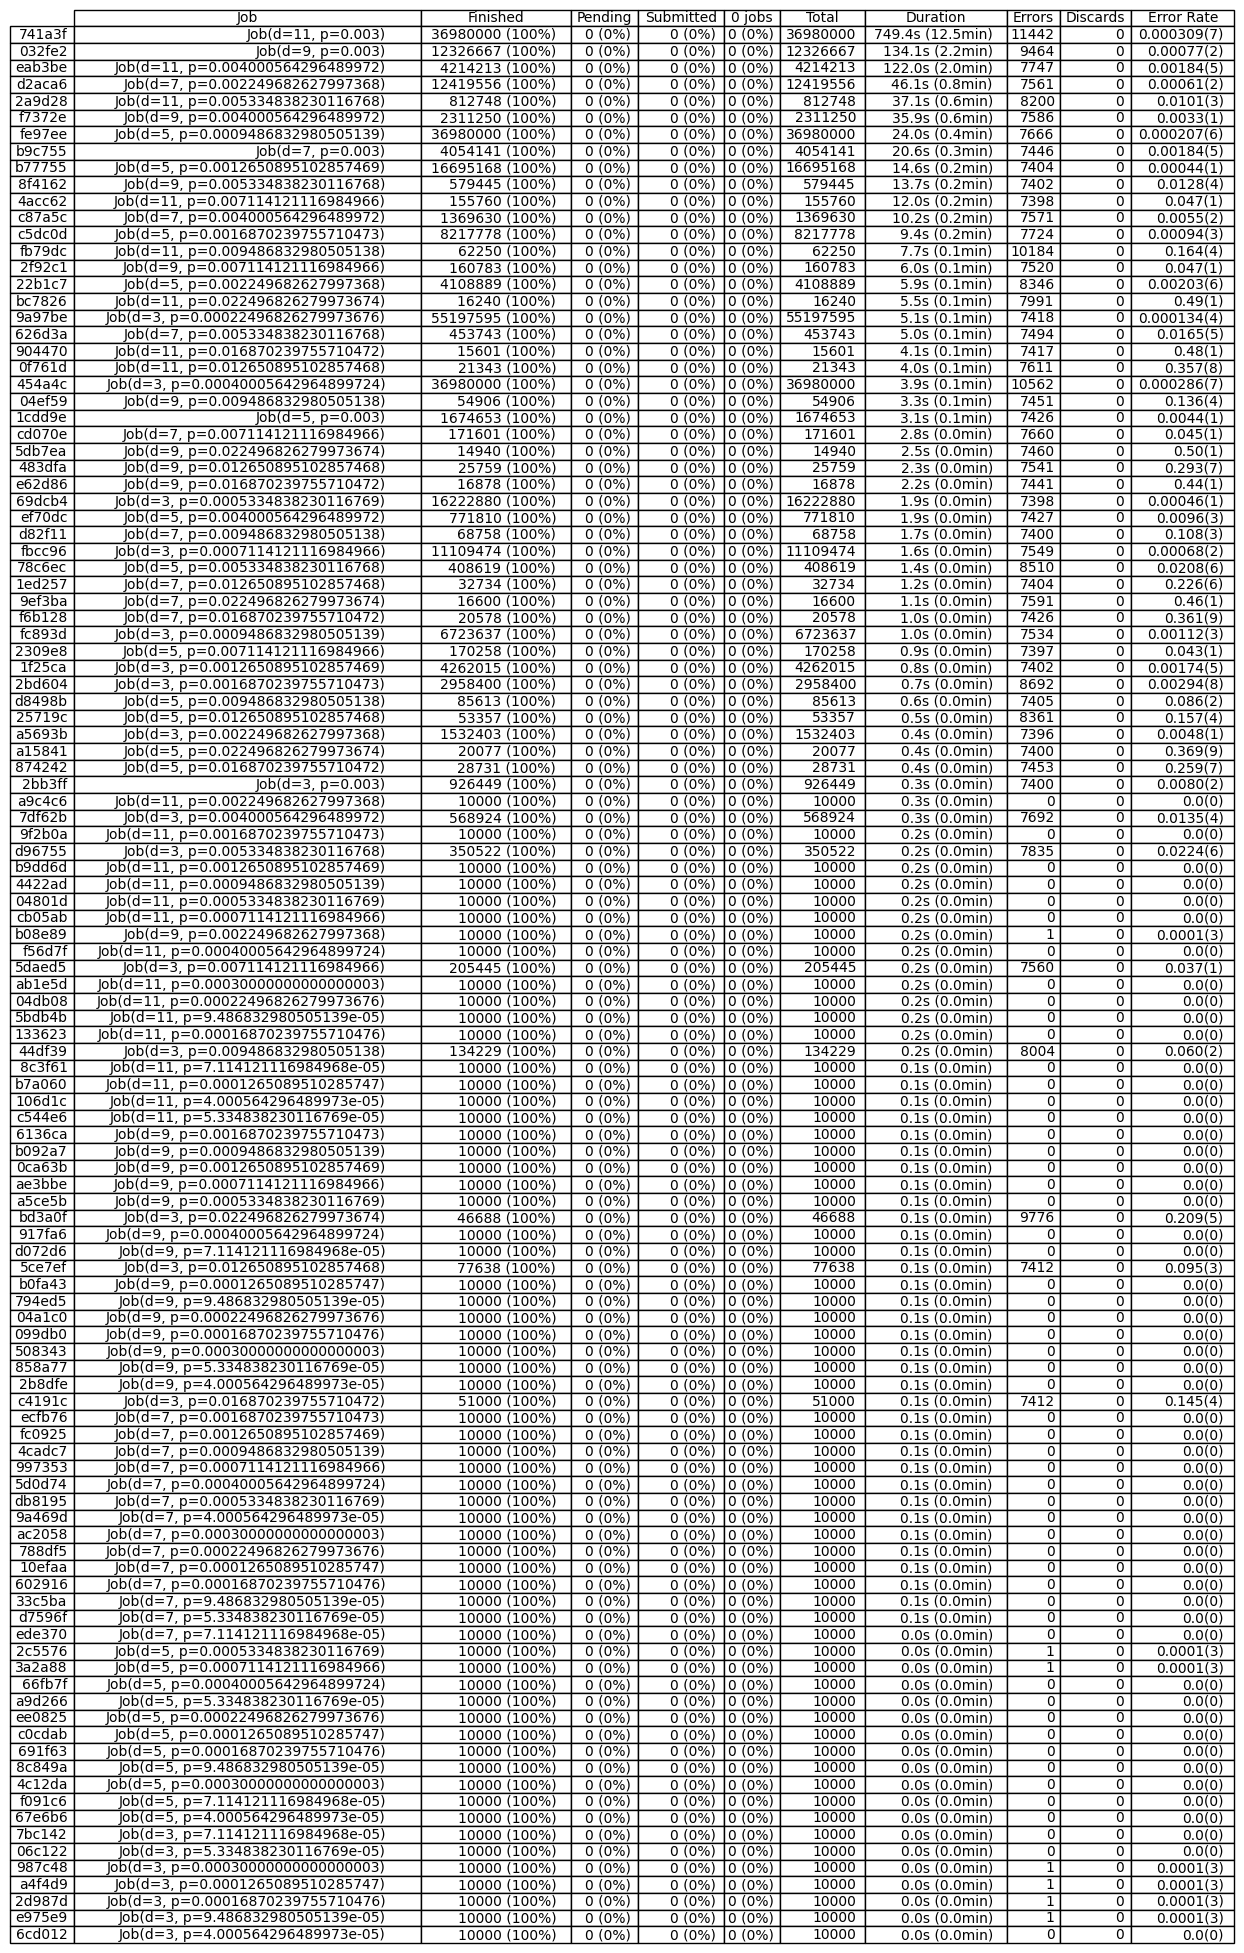

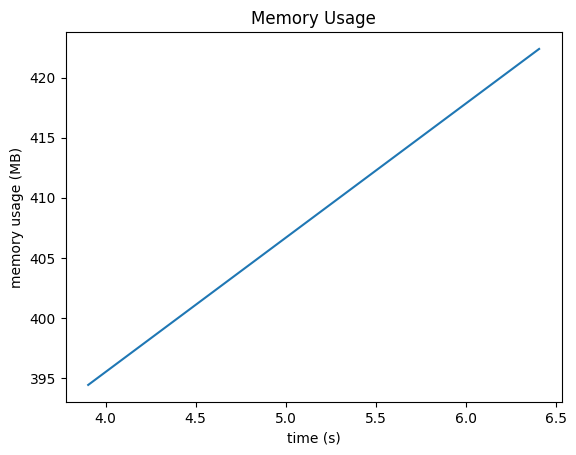

In [7]:
plotter = LogicalErrorRatePlotter(d_vec, p_vec)
progress_plotter = JobProgressPlotter()
memory_plotter = MemoryUsagePlotter()
def callback(executor: MonteCarloJobExecutor):
    plotter(executor)
    progress_plotter(executor)
    memory_plotter(executor)

## The rest of the notebook runs the evaluation

Start a cluster by intelligently choose Slurm or Local cluster.

In [8]:
if not mark_finished:
    try:
        from dask_jobqueue import SLURMCluster
        from dask.distributed import Client
        n_workers = slurm_maximum_jobs // slurm_cores_per_node
        assert n_workers <= 200, "Yale HPC forbids submitting more than 200 jobs per hour"
        slurm_job_folder = os.path.join(os.path.abspath(os.getcwd()), "slurm_job")
        cluster = SLURMCluster(
            queue=slurm_partition,
            cores=slurm_cores_per_node,
            processes=slurm_cores_per_node,
            memory=f"{slurm_mem_per_job * slurm_cores_per_node} GB",
            walltime=slurm_walltime,
            job_extra_directives=[f'--out="{slurm_job_folder}/%j.out"', f'--error="{slurm_job_folder}/%j.err"'],
        )
        print(cluster.job_script())
        # cluster.scale(slurm_maximum_jobs)
        cluster.adapt(minimum=slurm_maximum_jobs, maximum=slurm_maximum_jobs)  # allow respawn
        if shudown_cluster is None:
            shudown_cluster = True
    except Exception as e:
        print(e)
        from dask.distributed import Client, LocalCluster
        cluster = LocalCluster(n_workers=local_maximum_jobs)
        if shudown_cluster is None:
            shudown_cluster = False
    print(cluster.dashboard_link)
    cluster

No module named 'dask_jobqueue'
http://127.0.0.1:8787/status


In [9]:
config = MonteCarloExecutorConfig()
config.max_submitted_job = max(config.max_submitted_job, 3 * slurm_maximum_jobs)
executor = MonteCarloJobExecutor(
    monte_carlo_function,
    jobs,
    config=config,
    filename=json_filename,
)

In [10]:
if mark_finished:
    callback(executor)
else:
    if shudown_cluster:
        print("will shut down the cluster after job finishes; if this is not desired, set `shudown_cluster` to False")
    with Client(cluster) as client:
        try:
            executor.execute(client, submitter, loop_callback=callback)
        finally:
            if shudown_cluster:
                print("shutting down the whole cluster; if this is not desired, set `shudown_cluster` to False")
                client.shutdown()